In [1]:
import numpy as np
import pandas as pd
import math
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
from tensorflow.keras.layers import Input, Add, Dense, Layer, Activation, concatenate,Conv2D, Flatten, MaxPooling2D,BatchNormalization, Dropout
from keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
import gc

# Clear the session
# K.clear_session()

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

class PrintShapeCallback(Callback):
    def __init__(self, model_layer_name):
        super(PrintShapeCallback, self).__init__()
        self.model_layer_name = model_layer_name

    def on_epoch_end(self, epoch, logs=None):
        # Get the output of the layer with the specified name
        layer_output = self.model.get_layer(self.model_layer_name).output
        print(f"After epoch {epoch+1}, shape of x (from layer {self.model_layer_name}): {layer_output.shape}")

print_shape_callback = PrintShapeCallback(model_layer_name='dense_1')  # Assuming 'dense_1' is the name of the Dense layer after h2(x)

class StopAtThresholdCallback(Callback):
    def __init__(self, threshold):
        super(StopAtThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_loss = logs.get('val_loss')
        if val_loss is not None and val_loss < self.threshold:
            print(f"\nStopping training as validation loss {val_loss} is below the threshold {self.threshold}")
            self.model.stop_training = True

# callback = StopAtThresholdCallback(threshold=1e-03)
callback = StopAtThresholdCallback(threshold=1.2962e-07)

class H1Layer(Layer):
    def __init__(self, **kwargs):
        super(H1Layer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.b = self.add_weight(shape=(input_shape[-1],),
                                initializer=RandomNormal(mean=0.0,stddev=0.03),
                                trainable=True)
        super(H1Layer, self).build(input_shape)

    def call(self, x):
        return (self.b * (2 * x))/ (2**(1/2) * np.pi**(1/4))
        #return (2 * x) 


class H2Layer(Layer):
    def __init__(self, **kwargs):
        super(H2Layer, self).__init__(**kwargs)

    def call(self, x, h1):
        return (((2*x*(h1)))-2)/(2*(np.pi**(1/4))*np.sqrt(math.factorial(2)))
    
class H3Layer(Layer):
    def __init__(self, **kwargs):
        super(H3Layer, self).__init__(**kwargs)
        
    def call(self, x, h1, h2):
        return (((2 * x * (h2)))-(4 * h1)) / (2**(3/2)*(np.pi**(1/4))*np.sqrt(math.factorial(3)))

class H4Layer(Layer):
    def __init__(self, **kwargs):
        super(H4Layer, self).__init__(**kwargs)

    def call(self, x, h2, h3):
        return (((2*x*(h3)))-(6*h2)) / (2**2 *(np.pi**(1/4))*np.sqrt(math.factorial(4)))

class H5Layer(Layer):
    def __init__(self, **kwargs):
        super(H5Layer,self).__init__(**kwargs)

    def call(self,x, h3, h4):
        return (((2 * x * h4)) - (8 * h3)) / (2**(5/2) * (np.pi**(1/4)) * np.sqrt(math.factorial(5)))

#FROM THIS ON NO MODIFICATION ON WEIGHTS
class H6Layer(Layer):
    def __init__(self, **kwargs):
        super(H6Layer,self).__init__(**kwargs)
        
    def call(self,x, h4, h5):
        return (2*x*(h5))-(10*h4)

class TensorDecompositionLayer(Layer):
    def __init__(self, rank, **kwargs):
        self.rank = rank
        super(TensorDecompositionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.factors_a = self.add_weight(shape=(input_shape[-1], self.rank),
                                         initializer=RandomNormal(mean=0.0,stddev=0.05),
                                         trainable=True)
        self.factors_b = self.add_weight(shape=(self.rank, input_shape[-1]),
                                        initializer=RandomNormal(mean=0.0,stddev=0.05),
                                        trainable=True)
        super(TensorDecompositionLayer, self).build(input_shape)

    def call(self, x):
        return tf.matmul(tf.matmul(x, self.factors_a), self.factors_b)

 
class Relu_With_Weight(Layer):
    def __init__(self, **kwargs):
        super(Relu_With_Weight, self).__init__(**kwargs)

    def build(self, input_shape):
        self.b = self.add_weight(shape=(input_shape[-1],),
                                initializer=RandomNormal(),
                                trainable=True)
        super(Relu_With_Weight, self).build(input_shape)

    def call(self, x):
        return K.tanh(x * self.b)
    


2024-05-15 12:57:13.554739: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-15 12:57:14.039424: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(48000, 28, 28, 1)
(6000, 28, 28, 1)
(6000, 28, 28, 1)


2024-05-15 12:53:03.954854: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 batch_normalization (Batch  (None, 28, 28, 1)            4         ['input_1[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 conv2d (Conv2D)             (None, 28, 28, 64)           640       ['batch_normalization[0][0]'] 
                                                                                                  
 h1_layer (H1Layer)          (None, 28, 28, 64)           64        ['conv2d[0][0]']          

2024-05-15 12:53:03.972531: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-15 12:53:03.972715: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-15 12:53:03.974616: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Epoch 1/15


2024-05-15 12:53:05.666804: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-05-15 12:53:06.421753: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-05-15 12:53:07.090701: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-05-15 12:53:07.091558: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f685cee2950 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-15 12:53:07.091569: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-05-15 12:53:07.094709: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] di

375/375 [==============================] - 7s 9ms/step - loss: 0.3498 - recall: 0.8503 - val_loss: 0.0683 - val_recall: 0.9773
Epoch 2/15
375/375 [==============================] - 3s 8ms/step - loss: 0.0824 - recall: 0.9725 - val_loss: 0.0468 - val_recall: 0.9830
Epoch 3/15
375/375 [==============================] - 3s 8ms/step - loss: 0.0614 - recall: 0.9787 - val_loss: 0.0418 - val_recall: 0.9865
Epoch 4/15
375/375 [==============================] - 3s 8ms/step - loss: 0.0550 - recall: 0.9816 - val_loss: 0.0401 - val_recall: 0.9858
Epoch 5/15
375/375 [==============================] - 3s 8ms/step - loss: 0.0470 - recall: 0.9843 - val_loss: 0.0396 - val_recall: 0.9872
Epoch 6/15
375/375 [==============================] - 3s 8ms/step - loss: 0.0412 - recall: 0.9864 - val_loss: 0.0344 - val_recall: 0.9883
Epoch 7/15
375/375 [==============================] - 3s 8ms/step - loss: 0.0398 - recall: 0.9865 - val_loss: 0.0298 - val_recall: 0.9900
Epoch 8/15
375/375 [=========================

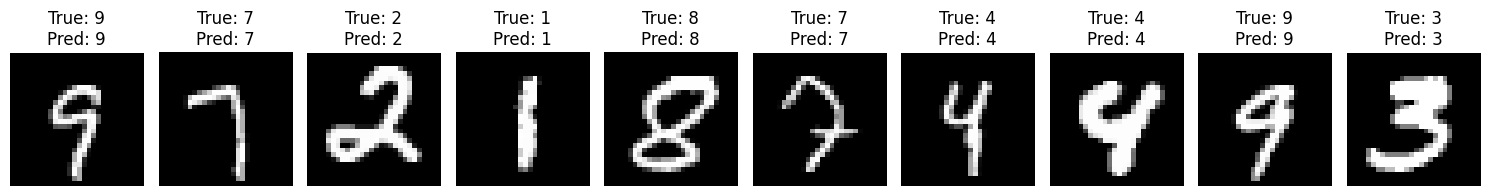

188/188 [==============================] - 0s 1ms/step


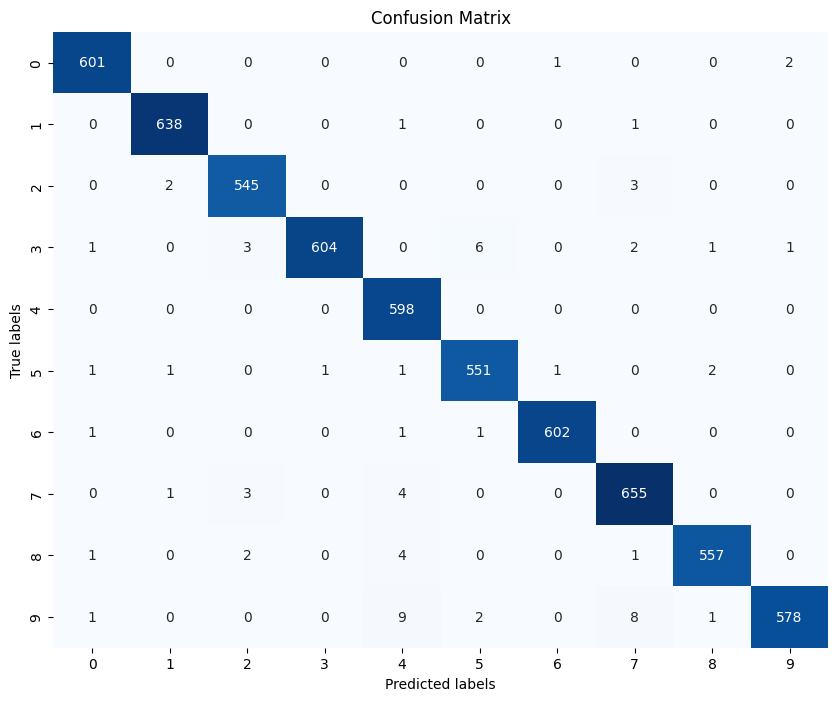

In [2]:
from tensorflow.keras.datasets import mnist
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.metrics import Recall


def build_model(input_shape, num_classes, filters):
    rank = 3
    input_layer = Input(shape=input_shape)
    x = input_layer

    h1 = H1Layer()
    h2 = H2Layer()
    h3 = H3Layer()
    h4 = H4Layer()
    h5 = H5Layer()
    h6 = H6Layer()
    #x = Conv2D(filters=64, kernel_size=(3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    #x = MaxPooling2D(pool_size=(2, 2))(x)
    #x = Conv2D(filters=128, kernel_size=(3, 3), padding='same')(x)
    x = Conv2D(filters=filters, kernel_size=(3, 3), padding='same',kernel_initializer="he_normal")(x)
    x = x_h1 = h1(x)
    x = Conv2D(filters=filters, kernel_size=(3, 3),padding='same',kernel_initializer="he_normal")(x)
    #x = TensorDecompositionLayer(rank)(x)
    x = x_h2 = h2(x,x_h1)
    x = Conv2D(filters=filters, kernel_size=(3, 3), padding='same',kernel_initializer="he_normal")(x)
    #x = TensorDecompositionLayer(rank)(x)
    x = x_h3 = h3(x,x_h1,x_h2)
    # x = Conv2D(filters=filters, kernel_size=(3, 3),padding='same',kernel_initializer="he_normal")(x)
    #x = TensorDecompositionLayer(rank)(x)
    # x = x_h4=h4(x,x_h2, x_h3)
    #x = Conv2D(filters=filters, kernel_size=(3, 3), padding='same')(x)
    #x = x_h5=h5(x,x_h3, x_h4)
    #x = TensorDecompositionLayer(rank)(x)
    x = Conv2D(filters=filters, kernel_size=(3, 3))(x)
    x = MaxPooling2D((4,4))(x)
    x = Dropout(rate=0.5)(x)
    x = Flatten()(x)


    #x = Dense(filters)(x)
    #x = x_h1 = h1(x)
    #x = Dense(filters)(x)
    # x = TensorDecompositionLayer(rank)(x)
    #x = x_h2 = h2(x,x_h1)
    #x = Dense(filters)(x)
    # x = TensorDecompositionLayer(rank)(x)
    #x = x_h3 = h3(x,x_h1,x_h2)
    #x = Dense(filters)(x)
    # x = TensorDecompositionLayer(rank)(x)
    #x = x_h4 = h4(x,x_h2, x_h3)
    #x = Dense(filters)(x)
    # x = TensorDecompositionLayer(rank)(x)
    #x = x_h5 = h5(x,x_h3, x_h4)
    # x = Dense(filters)(x)
    # x = TensorDecompositionLayer(rank)(x)
    # x = x_h6 = h6(x,x_h4, x_h5)
    # x = Dense(filters)(x)
    # x = TensorDecompositionLayer(rank)(x)


    output_layer = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=input_layer, outputs=output_layer)

    return model 


# Load and preprocess the MNIST data
(X_train, y_train), (X_val, y_val) = mnist.load_data()
X_train = X_train.reshape(-1, 28, 28, 1).astype('float32') / 255.0
X_val = X_val.reshape(-1, 28, 28, 1).astype('float32') / 255.0
y_train = to_categorical(y_train, 10)
y_val = to_categorical(y_val, 10)

#Divide data twice we get train, validation, testing
X_train, X_temp, y_train, y_temp = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

input_shape = (28, 28, 1)
filters = 64
model_mnist = build_model(input_shape, 10,filters)
optimizer = Adam(learning_rate=0.001)
model_mnist.summary()
model_mnist.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=[Recall()])

batch_size = 128
epochs = 15

history = model_mnist.fit(X_train, y_train,
                          batch_size=batch_size,
                          epochs=epochs,
                          verbose=1,
                          validation_data=(X_val, y_val))

val_loss, val_acc = model_mnist.evaluate(X_test, y_test, verbose=0)
print(f"Validation accuracy: {val_acc:.4f}")

# Visualize some sample predictions
num_test_samples = 10
indices = np.random.choice(len(X_val), num_test_samples)
X_test_samples = X_test[indices]
y_true_samples = np.argmax(y_test[indices], axis=1)
y_pred_samples = np.argmax(model_mnist.predict(X_test_samples), axis=1)

plt.figure(figsize=(15, 5))
for i in range(num_test_samples):
    plt.subplot(2, num_test_samples, i + 1)
    plt.imshow(X_test_samples[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
    plt.title(f"True: {y_true_samples[i]}\nPred: {y_pred_samples[i]}")
plt.tight_layout()
plt.show()

# Heatmap
# Get the predictions for the validation set
y_pred_test = np.argmax(model_mnist.predict(X_test), axis=1)

# Convert true labels back to categorical from one-hot encoding
y_test_categorical = np.argmax(y_test, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test_categorical, y_pred_test)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [10]:
print('Train Data: ',X_train.shape)
print('Test Data', X_test.shape)
print('Validation Data', X_val.shape)

Train Data:  (48000, 28, 28, 1)
Test Data (6000, 28, 28, 1)
Validation Data (6000, 28, 28, 1)


29694

(48000, 28, 28, 1)
(6000, 28, 28, 1)
(6000, 28, 28, 1)


2024-05-15 12:57:16.508277: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-15 12:57:16.526954: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-15 12:57:16.527150: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 batch_normalization (Batch  (None, 28, 28, 1)            4         ['input_1[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 conv2d (Conv2D)             (None, 28, 28, 64)           640       ['batch_normalization[0][0]'] 
                                                                                                  
 h1_layer (H1Layer)          (None, 28, 28, 64)           64        ['conv2d[0][0]']          

s-bus-pci#L344-L355
2024-05-15 12:57:16.529363: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-15 12:57:16.529489: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-15 12:57:16.954155: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentat

Epoch 1/15


2024-05-15 12:57:18.276553: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-05-15 12:57:19.055856: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-05-15 12:57:19.733100: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-05-15 12:57:19.734286: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fd34d5979d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-15 12:57:19.734298: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-05-15 12:57:19.737513: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] di

375/375 [==============================] - 7s 9ms/step - loss: 0.3587 - recall: 0.8480 - val_loss: 0.0979 - val_recall: 0.9615
Epoch 2/15
375/375 [==============================] - 3s 8ms/step - loss: 0.0837 - recall: 0.9713 - val_loss: 0.0538 - val_recall: 0.9812
Epoch 3/15
375/375 [==============================] - 3s 8ms/step - loss: 0.0665 - recall: 0.9778 - val_loss: 0.0450 - val_recall: 0.9850
Epoch 4/15
375/375 [==============================] - 3s 8ms/step - loss: 0.0550 - recall: 0.9815 - val_loss: 0.0441 - val_recall: 0.9840
Epoch 5/15
375/375 [==============================] - 3s 8ms/step - loss: 0.0510 - recall: 0.9834 - val_loss: 0.0366 - val_recall: 0.9857
Epoch 6/15
375/375 [==============================] - 3s 8ms/step - loss: 0.0457 - recall: 0.9844 - val_loss: 0.0354 - val_recall: 0.9895
Epoch 7/15
375/375 [==============================] - 3s 8ms/step - loss: 0.0422 - recall: 0.9856 - val_loss: 0.0302 - val_recall: 0.9900
Epoch 8/15
375/375 [=========================

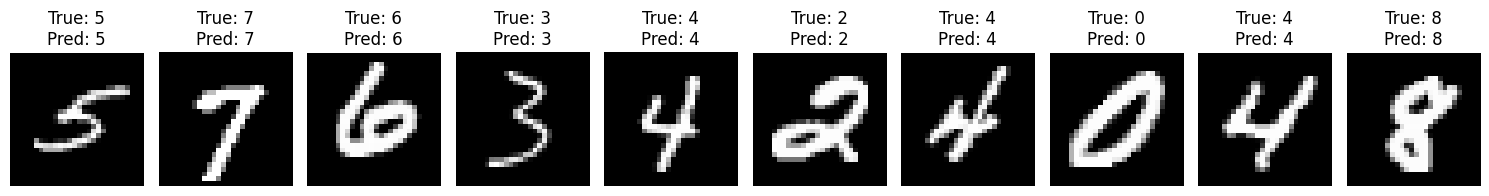

188/188 [==============================] - 0s 1ms/step


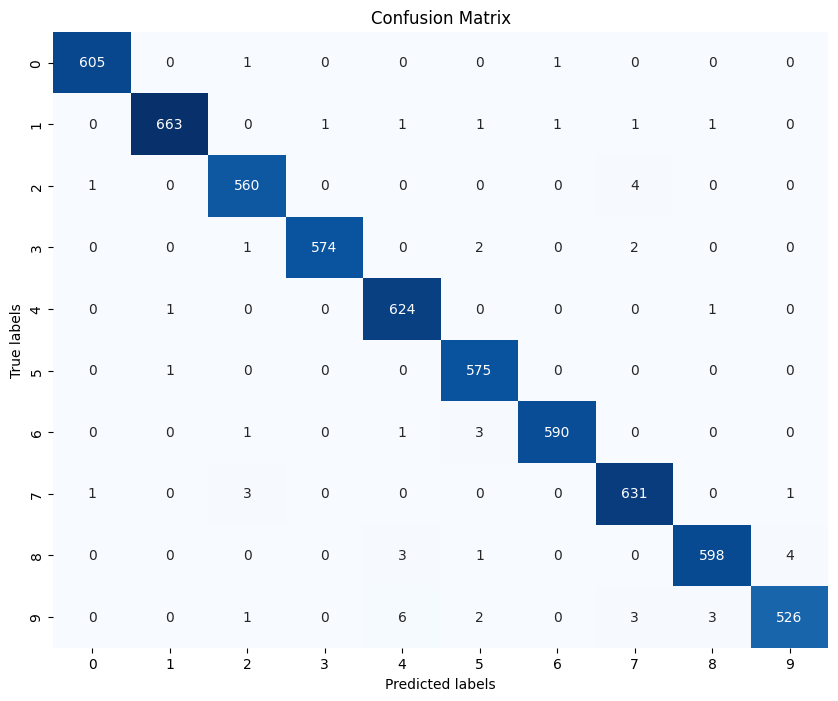

In [2]:
# Clear the session to free up GPU memory
tf.keras.backend.clear_session()

#FORGET PREVIOUS MODEL
del model_mnist
gc.collect()

# Delete the model and call garbage collector
from tensorflow.keras.datasets import mnist
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.metrics import Recall


def build_model(input_shape, num_classes, filters):
    rank = 3
    input_layer = Input(shape=input_shape)
    x = input_layer

    h1 = H1Layer()
    h2 = H2Layer()
    h3 = H3Layer()
    h4 = H4Layer()
    h5 = H5Layer()
    h6 = H6Layer()
    #x = Conv2D(filters=64, kernel_size=(3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    #x = MaxPooling2D(pool_size=(2, 2))(x)
    #x = Conv2D(filters=128, kernel_size=(3, 3), padding='same')(x)
    x = Conv2D(filters=filters, kernel_size=(3, 3), padding='same',kernel_initializer="he_normal")(x)
    x = x_h1 = h1(x)
    x = Conv2D(filters=filters, kernel_size=(3, 3),padding='same',kernel_initializer="he_normal")(x)
    #x = TensorDecompositionLayer(rank)(x)
    x = x_h2 = h2(x,x_h1)
    x = Conv2D(filters=filters, kernel_size=(3, 3), padding='same',kernel_initializer="he_normal")(x)
    #x = TensorDecompositionLayer(rank)(x)
    x = x_h3 = h3(x,x_h1,x_h2)
    # x = Conv2D(filters=filters, kernel_size=(3, 3),padding='same',kernel_initializer="he_normal")(x)
    #x = TensorDecompositionLayer(rank)(x)
    # x = x_h4=h4(x,x_h2, x_h3)
    #x = Conv2D(filters=filters, kernel_size=(3, 3), padding='same')(x)
    #x = x_h5=h5(x,x_h3, x_h4)
    #x = TensorDecompositionLayer(rank)(x)
    x = Conv2D(filters=filters, kernel_size=(3, 3))(x)
    x = MaxPooling2D((4,4))(x)
    x = Dropout(rate=0.5)(x)
    x = Flatten()(x)


    #x = Dense(filters)(x)
    #x = x_h1 = h1(x)
    #x = Dense(filters)(x)
    # x = TensorDecompositionLayer(rank)(x)
    #x = x_h2 = h2(x,x_h1)
    #x = Dense(filters)(x)
    # x = TensorDecompositionLayer(rank)(x)
    #x = x_h3 = h3(x,x_h1,x_h2)
    #x = Dense(filters)(x)
    # x = TensorDecompositionLayer(rank)(x)
    #x = x_h4 = h4(x,x_h2, x_h3)
    #x = Dense(filters)(x)
    # x = TensorDecompositionLayer(rank)(x)
    #x = x_h5 = h5(x,x_h3, x_h4)
    # x = Dense(filters)(x)
    # x = TensorDecompositionLayer(rank)(x)
    # x = x_h6 = h6(x,x_h4, x_h5)
    # x = Dense(filters)(x)
    # x = TensorDecompositionLayer(rank)(x)


    output_layer = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=input_layer, outputs=output_layer)

    return model 


# Load and preprocess the MNIST data
(X_train, y_train), (X_val, y_val) = mnist.load_data()
X_train = X_train.reshape(-1, 28, 28, 1).astype('float32') / 255.0
X_val = X_val.reshape(-1, 28, 28, 1).astype('float32') / 255.0
y_train = to_categorical(y_train, 10)
y_val = to_categorical(y_val, 10)

#Divide data twice we get train, validation, testing
X_train, X_temp, y_train, y_temp = train_test_split(X_train, y_train, test_size=0.2, random_state=66)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=66)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

input_shape = (28, 28, 1)
filters = 64
model_mnist = build_model(input_shape, 10,filters)
optimizer = Adam(learning_rate=0.001)
model_mnist.summary()
model_mnist.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=[Recall()])

batch_size = 128
epochs = 15

history = model_mnist.fit(X_train, y_train,
                          batch_size=batch_size,
                          epochs=epochs,
                          verbose=1,
                          validation_data=(X_val, y_val))

val_loss, val_acc = model_mnist.evaluate(X_test, y_test, verbose=0)
print(f"Validation accuracy: {val_acc:.4f}")

# Visualize some sample predictions
num_test_samples = 10
indices = np.random.choice(len(X_val), num_test_samples)
X_test_samples = X_test[indices]
y_true_samples = np.argmax(y_test[indices], axis=1)
y_pred_samples = np.argmax(model_mnist.predict(X_test_samples), axis=1)

plt.figure(figsize=(15, 5))
for i in range(num_test_samples):
    plt.subplot(2, num_test_samples, i + 1)
    plt.imshow(X_test_samples[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
    plt.title(f"True: {y_true_samples[i]}\nPred: {y_pred_samples[i]}")
plt.tight_layout()
plt.show()

# Heatmap == CONFUCION MATRIX
# Get the predictions for the validation set
y_pred_test = np.argmax(model_mnist.predict(X_test), axis=1)

# Convert true labels back to categorical from one-hot encoding
y_test_categorical = np.argmax(y_test, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test_categorical, y_pred_test)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


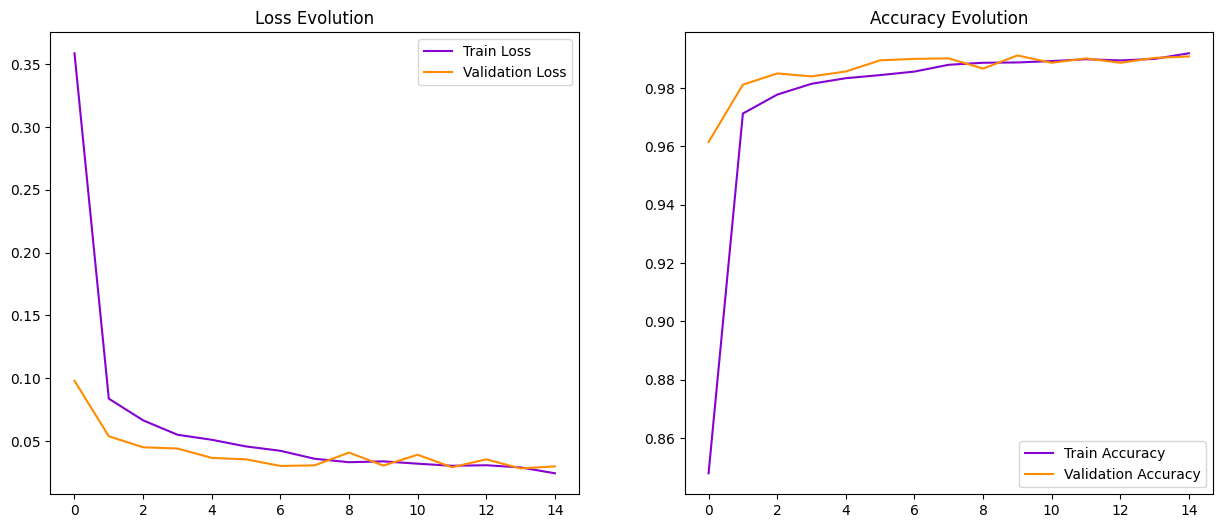

: 

In [4]:
plt.figure(figsize=(15,6))

# Plotting the training and validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='#8502d1')
plt.plot(history.history['val_loss'], label='Validation Loss', color='darkorange')
plt.legend()
plt.title('Loss Evolution')

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['recall'], label='Train Accuracy', color='#8502d1')
plt.plot(history.history['val_recall'], label='Validation Accuracy', color='darkorange')
plt.legend()
plt.title('Accuracy Evolution')

plt.show()